In [1]:
%reset -f
testID = 0

In [2]:
import os
import shutil

import pandas as pd
import numpy as np
import math as mt
import matplotlib.pyplot as plt
import seaborn as sns

# Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils import plot_model

# SkLearn
import sklearn.preprocessing as SklPreProcessing
import sklearn.metrics as SklMetrics
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score


%matplotlib inline

Using TensorFlow backend.


In [3]:
class Scoring_Functions():
    #
    def __init__(self, y_pred, y_true):
        self.y_pred = y_pred
        self.y_true = y_true
    #
    def accuracy(self):
        # http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score
        return str(accuracy_score(self.y_true, self.y_pred) * 100) + "%"
    #
    def precision(self):
        # http: // scikit - learn.org / stable / modules / generated / sklearn.metrics.precision_score.html  # sklearn.metrics.precision_score
        return str(precision_score(self.y_true, self.y_pred, average='weighted')* 100) + '%'
    #
    def recall(self):
        # http://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score
        return str(recall_score(self.y_true, self.y_pred, average='weighted') * 100) + '%'
    #
    def f_measure(self):
        # http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score
        return str(f1_score(self.y_true, self.y_pred, average='weighted') * 100) + '%'
    #
    def scoring_results(self):
        return "Accuracy: " + str(self.accuracy()) + "\nPrecision: " + str(self.precision()) + "\nRecall: " + str(self.recall()) + "\nFMeasure: " + str(self.f_measure())

In [52]:
class LSTMPredictor:
    ############################
    # MetaData
    __testID = None
    __cmdCount = 0
    __cmdHistory = ''
    __resultsRootDir = 'results'
    ############################
    # Dataset info
    __eegData = None
    __eegHeader = None
    __dataFileName = None
    ############################
    # ML model info
    __model = None
    __trainTestMap = None
    ############################
   
    def __init__(self, __testID, filename):
        self.__testID = str(__testID).zfill(5)
        self.__createTestResultsDir()
        self.__dataFileName = filename
        self.ResetState()
        
    def ResetState(self, filename=None):
        tmpFileName = ''
        self.__cmdHistory = ''
        self.__cmdCount = 0
        
        if filename is None:
            tmpFileName = self.__dataFileName
        else:
            tmpFileName = filename
            
        self.__loadData(tmpFileName)
    
    ###########################################################################
    # Plot methods
    def PlotFeatures(self, filePrefix=None, figWidth=20, figHeight=20):
        self.__addToHistory('PlotFeatures_filePrefix:' + str(filePrefix))
        fig = plt.figure()
        fig.set_figwidth(figWidth)
        fig.set_figheight(figHeight)
        
        featureCount = len(self.__eegHeader) - 1
        idxSubplot = 0
        
        for itr in range(featureCount):
            idxSubplot = idxSubplot + 1
            currAx = fig.add_subplot(featureCount + 1, 1, idxSubplot)
            currAx.grid()
            currAx.plot(self.__eegData[:, itr])
            currAx.set_title(self.__eegHeader[itr])
        
        idxSubplot = idxSubplot + 1
        currAx = fig.add_subplot(featureCount + 1, 1, idxSubplot)
        currAx.grid()
        currAx.plot(self.__eegData[:, -1])
        currAx.set_title(self.__eegHeader[-1])

        if filePrefix is None:
            plt.show()
        else:
            pathToFile = self.__resultsRootDir + "/" + self.__testID + "/" + filePrefix
            plt.savefig(pathToFile)
            
    def PlotBoxPlots(self, filePrefix=None, figWidth=20, figHeight=20):
        self.__addToHistory('PlotBoxPlots_filePrefix:' + str(filePrefix))
        fig = plt.figure()
        fig.set_figwidth(figWidth)
        fig.set_figheight(figHeight)
        
        ax1 = fig.add_subplot(2, 1, 1)
        ax1.set_title('Feature range: Full')
        ax1.boxplot(self.__eegData[:, :-1]
                    , sym='b.'
                    , vert=False
                    , whis='range'
                    , labels=self.__eegHeader[:-1]
                    , meanline=True
                    , showbox=True
                    , showfliers=True)
        
        ax2 = fig.add_subplot(2, 1, 2)
        ax2.set_title('Feature range: [5%, 95%]')
        ax2.boxplot(self.__eegData[:, :-1]
                    , sym='b.'
                    , vert=False
                    , whis=[5, 95]
                    , labels=self.__eegHeader[:-1]
                    , meanline=True
                    , showbox=True
                    , showfliers=False)
        
        if filePrefix is not None:
            pathToFile = self.__resultsRootDir + "/" + self.__testID + "/" + filePrefix
            plt.savefig(pathToFile)
            
    def PlotMeanDistribution(self, filePrefix=None, figWidth=20, figHeight=20):
        self.__addToHistory('PlotMeanDistribution_filePrefix:' + str(filePrefix))
        idxEyeClosed = np.where(self.__eegData[:, -1] == 1)[0]
        idxEyeOpened = np.where(self.__eegData[:, -1] == 0)[0]
        
        featureCount = len(self.__eegHeader) - 1
        xTick = np.array(range(featureCount))
        
        fig = plt.figure()
        fig.set_figwidth(figWidth)
        fig.set_figheight(figHeight)

        ax = fig.add_subplot(1, 1, 1)
        ax.grid()
        ax.set_title('Mean Distribution')
        ax.set_xticklabels(self.__eegHeader[0:-1])
        ax.set_xticks(xTick)

        ax.plot(xTick, self.__eegData[idxEyeOpened][:, 0:featureCount].mean(axis=0), 'bo')
        ax.plot(xTick, self.__eegData[idxEyeClosed][:, 0:featureCount].mean(axis=0), 'ro')
        ax.plot(xTick, self.__eegData[:, 0:featureCount].mean(axis=0), 'go')

        ax.legend(['Eye Open', 'Eye Closed', 'Both'])
        
        if filePrefix is not None:
            pathToFile = self.__resultsRootDir + "/" + self.__testID + "/" + filePrefix
            plt.savefig(pathToFile)

    def PlotStdDevDistribution(self, filePrefix=None, figWidth=20, figHeight=20):
        self.__addToHistory('PlotStdDevDistribution_filePrefix:' + str(filePrefix))
        idxEyeClosed = np.where(self.__eegData[:, -1] == 1)[0]
        idxEyeOpened = np.where(self.__eegData[:, -1] == 0)[0]
        
        featureCount = len(self.__eegHeader) - 1
        xTick = np.array(range(featureCount))
        
        fig = plt.figure()
        fig.set_figwidth(figWidth)
        fig.set_figheight(figHeight)

        ax = fig.add_subplot(1, 1, 1)
        ax.grid()
        ax.set_title('Standard Deviation Distribution')
        ax.set_xticklabels(self.__eegHeader[0:-1])
        ax.set_xticks(xTick)

        ax.plot(xTick, self.__eegData[idxEyeOpened][:, 0:featureCount].std(axis=0), 'bo')
        ax.plot(xTick, self.__eegData[idxEyeClosed][:, 0:featureCount].std(axis=0), 'ro')
        ax.plot(xTick, self.__eegData[:, 0:featureCount].std(axis=0), 'go')

        ax.legend(['Eye Open', 'Eye Closed', 'Both'])
        
        if filePrefix is not None:
            pathToFile = self.__resultsRootDir + "/" + self.__testID + "/" + filePrefix
            plt.savefig(pathToFile)
            
    def FeatureCorrelationMatrix(self, filePrefix=None, figWidth=20, figHeight=20):
        self.__addToHistory('FeatureCorrelationMatrix_filePrefix:' + str(filePrefix))
        # Compute the correlation matrix
        corr = pd.DataFrame(data=self.__eegData[:, :-1], columns=list(self.__eegHeader[:-1])).corr()
        
        # Generate a mask for the upper triangle
        mask = np.zeros_like(corr, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        
        # Set up the matplotlib figure
        fig = plt.figure()
        fig.set_figwidth(figWidth)
        fig.set_figheight(figHeight)
        
        ax = fig.add_subplot(1, 1, 1)
        ax.set_title("Feature correlation matrix")
        
        # Generate a custom diverging colormap
        cmap = sns.diverging_palette(240, 10, as_cmap=True)
        
        # Draw the heatmap
        sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin=-1.0, center=0,
                    square=True, linewidths=.5, cbar_kws={"shrink": .5})
        
        if filePrefix is not None:
            pathToFile = self.__resultsRootDir + "/" + self.__testID + "/" + filePrefix
            plt.savefig(pathToFile)

    ###########################################################################
    # Getters
    def GetFeatureNames(self):
        return self.__eegHeader[:-1]
    
    def GetCmdHistory(self):
        return self.__cmdHistory
    ###########################################################################
    # Dataset operations
    def RemoveFeatures(self, indices):
        assert isinstance(indices, list), 'Parameter must be a list'

        self.__addToHistory('RemoveFeatures:' + ','.join(str(x) for x in indices))
        self.__eegHeader = np.delete(self.__eegHeader, indices)
        self.__eegData = np.delete(self.__eegData, indices, axis=1)
    
    def RemoveOutliers(self, upperLimit=None, lowerLimit=None):
        outLierIndexes = set()
        result = {}
        result['upper'] = set()
        result['lower'] = set()
        
        self.__addToHistory('RemoveOutliers_Upper:' + str(upperLimit)
                            + '_Lower:' + str(lowerLimit))
        featureCount = len(self.__eegHeader) - 1

        if upperLimit is not None:
            for itr in range(featureCount):
                outLiers = np.where(self.__eegData[:, itr] > upperLimit)[0]
                if len(outLiers) > 0:
                    for i in xrange(len(outLiers)):
                        result['upper'].add(outLiers[i])

        if lowerLimit is not None:
            for itr in range(featureCount):
                outLiers = np.where(self.__eegData[:, itr] < lowerLimit)[0]
                if len(outLiers) > 0:
                    for i in xrange(len(outLiers)):
                        result['lower'].add(outLiers[i])
                        
        deleteIndexes = list(result['upper'].union(result['lower']))
        self.__eegData = np.delete(self.__eegData, deleteIndexes, axis=0)
        
        return result

    def NormalizeData(self, normFunc='MinMax'):
        self.__addToHistory('NormalizeData_Func:' + normFunc)
        
        if normFunc == 'MinMax':
            scaler = SklPreProcessing.MinMaxScaler(feature_range=(0, 1))
            self.__eegData = scaler.fit_transform(self.__eegData)
        else:
            self.__eegData = normalize(self.__eegData, norm=normFunc)
        
    ###########################################################################
    # Keras LSTM model
    def CompileModel(self, lagCount, testSetRatio, neuronCount, dropOut,
                     modelArchitectureFilename, useLaggedOutput=True,
                     lossFunc='mae', optimizerFunc='adam'):
        self.__addToHistory('CompileModel_Lag:' + str(lagCount)
                            + '_TestSize:' + str(testSetRatio)
                            + '_NeuronCount:' + str(neuronCount)
                            + '_DropOut:' + str(dropOut)
                            + '_useLaggedOutput:' + str(useLaggedOutput)
                            + '_LossFunc:' + str(lossFunc)
                            + '_OptimizerFunc:' + str(optimizerFunc))
        
        supervisedDataset = self.__timeSeriesToSupervised(lagCount, useLaggedOutput)
        featureCount = len(self.__eegHeader) - 1
        
        splitPoint = int(testSetRatio * supervisedDataset.shape[0])
        values = supervisedDataset.values
        
        trainingSet = values[:splitPoint, :]
        testingSet = values[splitPoint:, :]
        
        ################################################
        print '(featureCount + 1) * lagCount: ', (featureCount + 1) * lagCount
        pastInputCount = (featureCount + 1) * lagCount
        ################################################
        
        self.__trainTestMap = {}

        self.__trainTestMap['trainingSet_inFeatures'] = trainingSet[:, :pastInputCount]
        self.__trainTestMap['trainingSet_outFeature'] = trainingSet[:, -1]
        
        print 'trainingSet.shape: ', trainingSet.shape
        print "self.__trainTestMap['trainingSet_inFeatures'].shape: ", self.__trainTestMap['trainingSet_inFeatures'].shape
        
        self.__trainTestMap['testingSet_inFeatures'] = testingSet[:, :pastInputCount]
        self.__trainTestMap['testingSet_outFeature'] = testingSet[:, -1]
        
        # Reshape input to be 3D [samples, timesteps, features]
#         featureDimSize = (((featureCount + 1) * lagCount) + featureCount) / lagCount
        featureDimSize = (featureCount + 1)
        
        self.__trainTestMap['trainingSet_inFeatures_reShaped'] = self.__trainTestMap['trainingSet_inFeatures'].reshape(
            (self.__trainTestMap['trainingSet_inFeatures'].shape[0], lagCount, featureDimSize))
        
#         print self.__trainTestMap['trainingSet_inFeatures_reShaped'].shape 
        
        self.__trainTestMap['testingSet_inFeatures_reShaped'] = self.__trainTestMap['testingSet_inFeatures'].reshape(
            (self.__trainTestMap['testingSet_inFeatures'].shape[0], lagCount, featureDimSize))
        
        # Design network
        self.__model = Sequential()
        
        self.__model.add(
            LSTM(neuronCount,
                 input_shape=(
                     self.__trainTestMap['trainingSet_inFeatures_reShaped'].shape[1],
                     self.__trainTestMap['trainingSet_inFeatures_reShaped'].shape[2]),
                 return_sequences=True
                )
        )
        self.__model.add(LSTM(neuronCount, return_sequences=True))
#         self.__model.add(LSTM(neuronCount, return_sequences=True))
#         self.__model.add(LSTM(neuronCount, return_sequences=True))
        self.__model.add(LSTM(neuronCount))

        
        self.__model.add(Dense(1))
        self.__model.compile(loss=lossFunc, optimizer=optimizerFunc)
        
        print self.__model.summary()
        
        # Visualize LSTM network
        pathToFile = self.__resultsRootDir + "/" + self.__testID + "/" + modelArchitectureFilename
        plot_model(self.__model, to_file=pathToFile, show_shapes=True)
        
    def FitModel(self, epochCount, batchSize,
                 resultsFile,
                 lossFuncFilePrefix=None,
                 predictionFilePrefix=None,
                 figWidth=20, figHeight=20, verbosity=2):
        assert self.__model != None, 'Model not compiled'
        
        self.__addToHistory('FitModel_EpochCount:' + str(epochCount)
                            + '_BatchSize:' + str(batchSize)
                            + '_lossFuncFilePrefix:' + str(lossFuncFilePrefix)
                            + '_predictionFilePrefix:' + str(predictionFilePrefix))
        
        # Fit model
        history = self.__model.fit(self.__trainTestMap['trainingSet_inFeatures_reShaped'],
                                 self.__trainTestMap['trainingSet_outFeature'],
                                 epochs=epochCount,
                                 batch_size=batchSize,
                                 validation_data=(
                                     self.__trainTestMap['testingSet_inFeatures_reShaped'],
                                     self.__trainTestMap['testingSet_outFeature']
                                 ),
                                 verbose=verbosity, shuffle=False)
        
        fig = plt.figure()
        fig.set_figwidth(figWidth)
        fig.set_figheight(figHeight)

        ax = fig.add_subplot(1, 1, 1)
        ax.grid()
        ax.set_title('Loss Function')
        ax.plot(history.history['loss'], label='train')
        ax.plot(history.history['val_loss'], label='test')
        plt.legend(['train', 'test'])
                    
        if lossFuncFilePrefix is not None:
            pathToFile = self.__resultsRootDir + "/" + self.__testID + "/" + lossFuncFilePrefix
            plt.savefig(pathToFile)

        testDataPrediction = self.__model.predict_classes(self.__trainTestMap['testingSet_inFeatures_reShaped'])
        testDataPredictionRaw = self.__model.predict(self.__trainTestMap['testingSet_inFeatures_reShaped'])
                
        scoringMetrics = Scoring_Functions(testDataPrediction, self.__trainTestMap['testingSet_outFeature'])
        self.__writeResultsToFile(resultsFile, scoringMetrics.scoring_results())
        print 'Results:\n' + scoringMetrics.scoring_results()

        fig = plt.figure()
        fig.set_figwidth(figWidth)
        fig.set_figheight(figHeight)
        
        ax1 = fig.add_subplot(3, 1, 1)
        ax1.grid()
        ax1.set_title('Expected')
        ax1.plot(self.__trainTestMap['testingSet_outFeature'])

        ax2 = fig.add_subplot(3, 1, 2)
        ax2.grid()
        ax2.set_title('Prediction - With rounding')
        ax2.plot(testDataPrediction)

        ax3 = fig.add_subplot(3, 1, 3)
        ax3.grid()
        ax3.set_title('Prediction - Without rounding')
        ax3.plot(testDataPredictionRaw)

        if predictionFilePrefix is not None:
            pathToFile = self.__resultsRootDir + "/" + self.__testID + "/" + predictionFilePrefix
            plt.savefig(pathToFile)

        # Reset __model
        self.__model = None
        self.__trainTestMap = None
    
    ###########################################################################
    # Private methods
    def __createTestResultsDir(self):
        dirName = "%s/%s" % (self.__resultsRootDir, self.__testID)
        if os.path.exists(dirName):
            shutil.rmtree(dirName)
        os.makedirs(dirName)
        
    def __loadData(self, filename):
        self.__eegData = np.genfromtxt(filename, delimiter=',', skip_header=1)
        self.__eegHeader = np.genfromtxt(filename, delimiter=',', max_rows=1, dtype=str)

    def __timeSeriesToSupervised(self, lagCount, useLaggedOutput):
        featureCount = len(self.__eegHeader) - 1

        cols, names = list(), list()
        dfInput = pd.DataFrame(self.__eegData[:, :-1])
        dfOutput = pd.DataFrame(self.__eegData[:, -1])
        
        for i in range(lagCount, 0, -1):
            cols.append(dfInput.shift(i))
            if useLaggedOutput:
                cols.append(dfOutput.shift(i))
            else:
                # Set the lagged output variable to a constant 0.5
                tmp = len(dfOutput.shift(i))
                cols.append(pd.DataFrame(np.ones(tmp) * 0.5))
            
            names += [('%s(t-%d)' % (self.__eegHeader[j], i)) for j in range(featureCount)]
            names += [('%s(t-%d)' % (self.__eegHeader[-1], i))]

        cols.append(dfInput)
        cols.append(dfOutput)
        names += [('%s(t)' % self.__eegHeader[j]) for j in range(featureCount)]
        names += [('%s(t)' % self.__eegHeader[-1])]

        agg = pd.concat(cols, axis=1)
        agg.columns = names

        # Drop rows containing NaN values
        agg.dropna(inplace=True)
        return agg
    
    def __addToHistory(self, newCmd):
        tmpStr = ''
        if self.__cmdCount > 0:
            tmpStr += '\n'
            for itr in range(self.__cmdCount):
                tmpStr += '+'
                
        tmpStr += newCmd
        self.__cmdHistory += tmpStr
        self.__cmdCount += 1
        
    def __writeResultsToFile(self, resFilename, results):
        pathToResultsFile = self.__resultsRootDir + "/" + self.__testID + "/" + resFilename
        resString = ''
        
        if os.path.exists(pathToResultsFile):
            resString = '\n\n-----------------------------------------------------------------\n'
            fileMode = 'a' # Append
        else:
            fileMode = 'w' # Create
        
        text_file = open(pathToResultsFile, fileMode)
        
        resString += 'Results:\n'
        resString += results
        resString += '\n\nCommand history:\n----------------\n'
        resString += self.__cmdHistory        

        text_file.write(resString)
        text_file.close()
    ###########################################################################

TestID:  37
(featureCount + 1) * lagCount:  15
trainingSet.shape:  (7487, 30)
self.__trainTestMap['trainingSet_inFeatures'].shape:  (7487, 15)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 1, 50)             13200     
_________________________________________________________________
lstm_31 (LSTM)               (None, 1, 50)             20200     
_________________________________________________________________
lstm_32 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 51        
Total params: 53,651
Trainable params: 53,651
Non-trainable params: 0
_________________________________________________________________
None
Train on 7487 samples, validate on 7488 samples
Epoch 1/100
 - 3s - loss: 0.4104 - val_loss: 0.1665
Epoch 2/100
 - 1s - lo

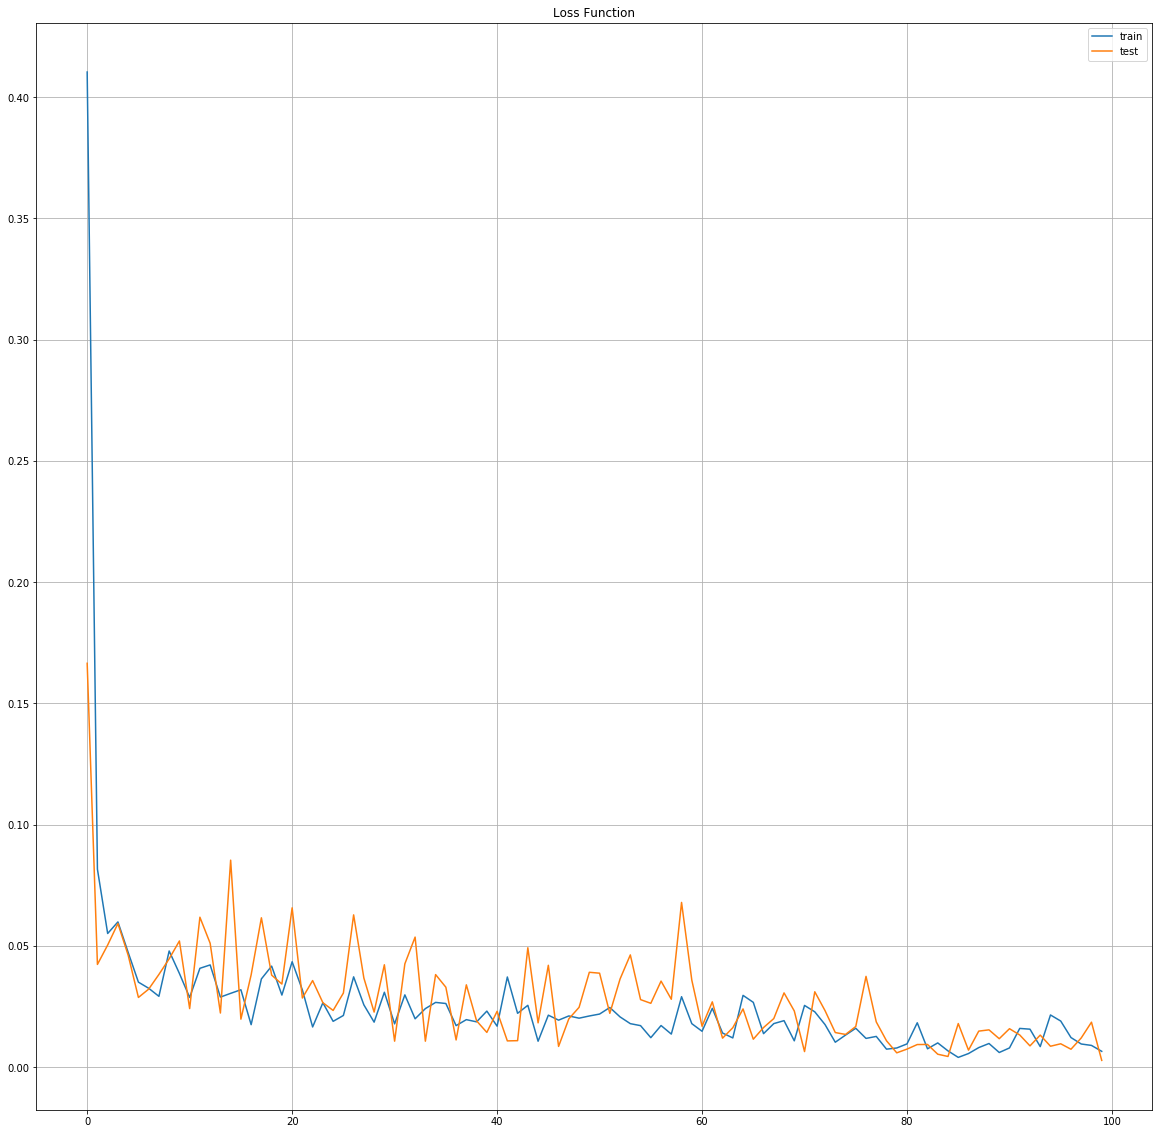

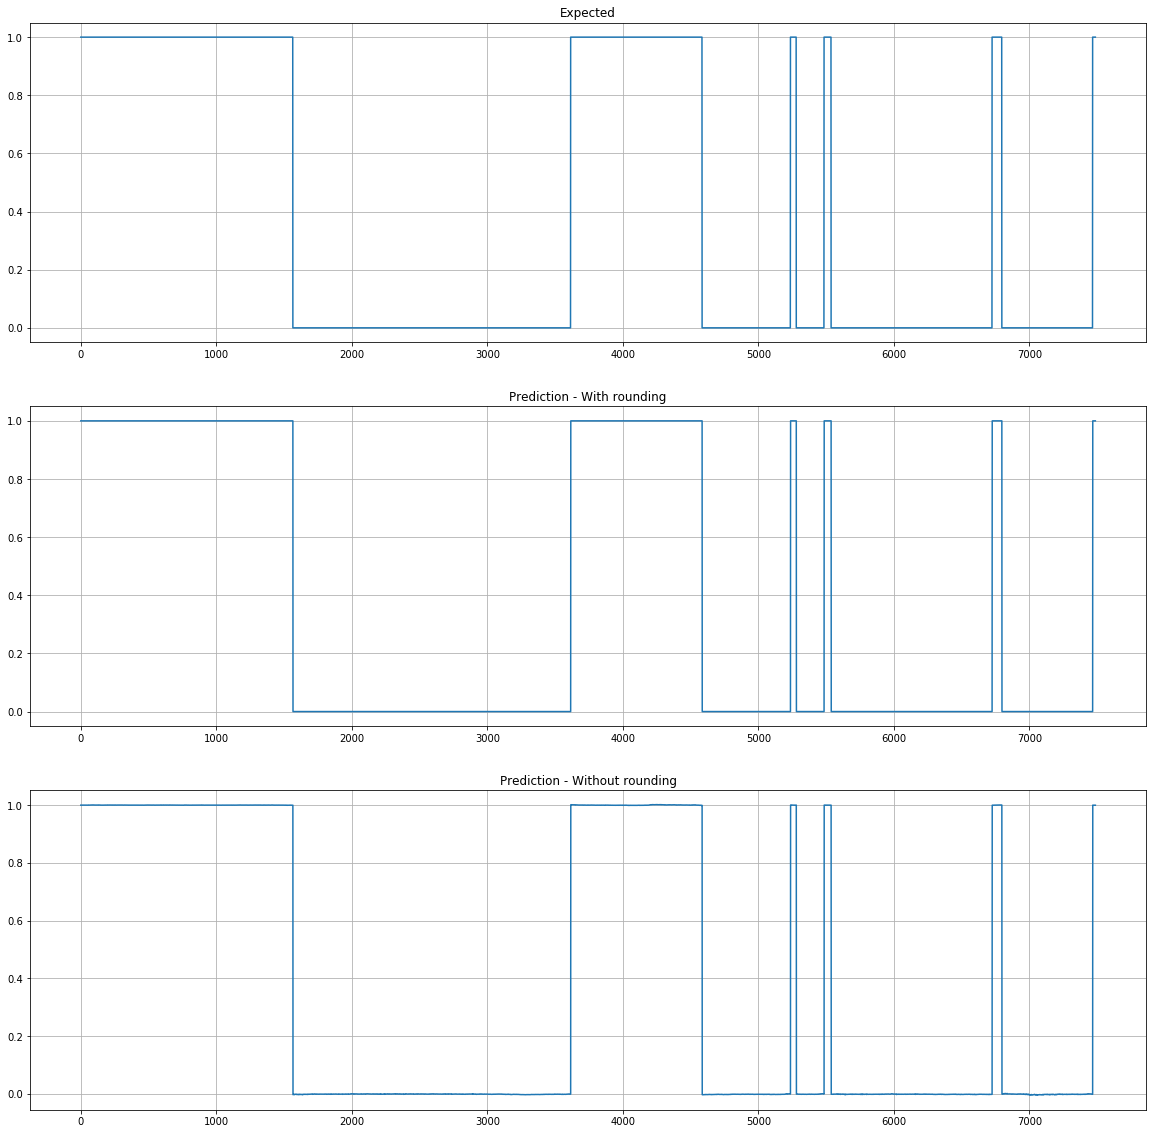

In [55]:
testID += 1

resultsFilename = 'TestResults.txt'
print "TestID: ", testID
a = LSTMPredictor(testID, 'EEGEyeState.arff.csv')


# a.RemoveFeatures([0, 1, 2, 3])

res = a.RemoveOutliers(upperLimit=5000)
a.NormalizeData()
# a.PlotFeatures(filePrefix='01_RawData')

lagValue = 1

a.CompileModel(lagCount=lagValue
               , testSetRatio=0.5
               , neuronCount=50
               , dropOut=0.0
               , useLaggedOutput=True
               , modelArchitectureFilename='01_modelArchitecture')

a.FitModel(epochCount=100
           , batchSize=50
           , resultsFile=resultsFilename
           , lossFuncFilePrefix='01_lossFile'
           , predictionFilePrefix='01_predictionFile'
           , verbosity=2)


print '\n\n-----------------------\n' + a.GetCmdHistory()


## Testing

In [73]:
leng = 3
data = [[i + j for j in range(leng)] for i in range(100)]
data = np.array(data, dtype=float)
print data.shape
print len(data)

target = [[i + j + 1 for j in range(leng)] for i in range(1, 101)]
target = np.array(target, dtype=float)
print target.shape
print len(target)

dataReShaped = data.reshape(len(data), 1, leng)
targetReShaped = target.reshape(len(target), 1, leng)

model = Sequential()

model.add(LSTM(leng, input_shape=(1, leng), return_sequences=True))
model.add(LSTM(leng, input_shape=(1, leng), return_sequences=True))
model.add(LSTM(leng, input_shape=(1, leng), return_sequences=True))
model.add(LSTM(leng, input_shape=(1, leng), return_sequences=True))
model.add(LSTM(leng, input_shape=(1, leng), return_sequences=True))
model.summary()


lossFunc='mae'
optimizerFunc='adam'

model.compile(loss=lossFunc, optimizer=optimizerFunc)

hist = model.fit(dataReShaped, targetReShaped, epochs=1000, batch_size=50, verbose=2,
                 validation_data=(dataReShaped, targetReShaped))


(100, 3)
100
(100, 3)
100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 1, 3)              84        
_________________________________________________________________
lstm_29 (LSTM)               (None, 1, 3)              84        
_________________________________________________________________
lstm_30 (LSTM)               (None, 1, 3)              84        
_________________________________________________________________
lstm_31 (LSTM)               (None, 1, 3)              84        
_________________________________________________________________
lstm_32 (LSTM)               (None, 1, 3)              84        
Total params: 420
Trainable params: 420
Non-trainable params: 0
_________________________________________________________________
Train on 100 samples, validate on 100 samples
Epoch 1/1000
 - 2s - loss: 52.5000 - val_loss: 52.4996
Epoch 2/1000
 - 0

 - 0s - loss: 52.2622 - val_loss: 52.2586
Epoch 129/1000
 - 0s - loss: 52.2575 - val_loss: 52.2539
Epoch 130/1000
 - 0s - loss: 52.2527 - val_loss: 52.2491
Epoch 131/1000
 - 0s - loss: 52.2479 - val_loss: 52.2443
Epoch 132/1000
 - 0s - loss: 52.2431 - val_loss: 52.2394
Epoch 133/1000
 - 0s - loss: 52.2382 - val_loss: 52.2345
Epoch 134/1000
 - 0s - loss: 52.2332 - val_loss: 52.2295
Epoch 135/1000
 - 0s - loss: 52.2282 - val_loss: 52.2243
Epoch 136/1000
 - 0s - loss: 52.2230 - val_loss: 52.2188
Epoch 137/1000
 - 0s - loss: 52.2174 - val_loss: 52.2133
Epoch 138/1000
 - 0s - loss: 52.2119 - val_loss: 52.2079
Epoch 139/1000
 - 0s - loss: 52.2065 - val_loss: 52.2025
Epoch 140/1000
 - 0s - loss: 52.2012 - val_loss: 52.1971
Epoch 141/1000
 - 0s - loss: 52.1957 - val_loss: 52.1916
Epoch 142/1000
 - 0s - loss: 52.1902 - val_loss: 52.1859
Epoch 143/1000
 - 0s - loss: 52.1844 - val_loss: 52.1798
Epoch 144/1000
 - 0s - loss: 52.1780 - val_loss: 52.1725
Epoch 145/1000
 - 0s - loss: 52.1705 - val_los

Epoch 272/1000
 - 0s - loss: 51.7561 - val_loss: 51.7558
Epoch 273/1000
 - 0s - loss: 51.7557 - val_loss: 51.7555
Epoch 274/1000
 - 0s - loss: 51.7554 - val_loss: 51.7552
Epoch 275/1000
 - 0s - loss: 51.7551 - val_loss: 51.7549
Epoch 276/1000
 - 0s - loss: 51.7548 - val_loss: 51.7546
Epoch 277/1000
 - 0s - loss: 51.7545 - val_loss: 51.7543
Epoch 278/1000
 - 0s - loss: 51.7542 - val_loss: 51.7540
Epoch 279/1000
 - 0s - loss: 51.7539 - val_loss: 51.7536
Epoch 280/1000
 - 0s - loss: 51.7536 - val_loss: 51.7534
Epoch 281/1000
 - 0s - loss: 51.7533 - val_loss: 51.7530
Epoch 282/1000
 - 0s - loss: 51.7530 - val_loss: 51.7528
Epoch 283/1000
 - 0s - loss: 51.7527 - val_loss: 51.7525
Epoch 284/1000
 - 0s - loss: 51.7524 - val_loss: 51.7522
Epoch 285/1000
 - 0s - loss: 51.7521 - val_loss: 51.7519
Epoch 286/1000
 - 0s - loss: 51.7518 - val_loss: 51.7516
Epoch 287/1000
 - 0s - loss: 51.7515 - val_loss: 51.7513
Epoch 288/1000
 - 0s - loss: 51.7512 - val_loss: 51.7510
Epoch 289/1000
 - 0s - loss: 51

Epoch 416/1000
 - 0s - loss: 51.7449 - val_loss: 51.7449
Epoch 417/1000
 - 0s - loss: 51.7449 - val_loss: 51.7449
Epoch 418/1000
 - 0s - loss: 51.7449 - val_loss: 51.7448
Epoch 419/1000
 - 0s - loss: 51.7448 - val_loss: 51.7448
Epoch 420/1000
 - 0s - loss: 51.7448 - val_loss: 51.7448
Epoch 421/1000
 - 0s - loss: 51.7448 - val_loss: 51.7448
Epoch 422/1000
 - 0s - loss: 51.7448 - val_loss: 51.7447
Epoch 423/1000
 - 0s - loss: 51.7447 - val_loss: 51.7447
Epoch 424/1000
 - 0s - loss: 51.7447 - val_loss: 51.7447
Epoch 425/1000
 - 0s - loss: 51.7447 - val_loss: 51.7447
Epoch 426/1000
 - 0s - loss: 51.7447 - val_loss: 51.7447
Epoch 427/1000
 - 0s - loss: 51.7446 - val_loss: 51.7446
Epoch 428/1000
 - 0s - loss: 51.7446 - val_loss: 51.7446
Epoch 429/1000
 - 0s - loss: 51.7446 - val_loss: 51.7446
Epoch 430/1000
 - 0s - loss: 51.7446 - val_loss: 51.7446
Epoch 431/1000
 - 0s - loss: 51.7446 - val_loss: 51.7445
Epoch 432/1000
 - 0s - loss: 51.7445 - val_loss: 51.7445
Epoch 433/1000
 - 0s - loss: 51

Epoch 560/1000
 - 0s - loss: 51.7426 - val_loss: 51.7426
Epoch 561/1000
 - 0s - loss: 51.7426 - val_loss: 51.7426
Epoch 562/1000
 - 0s - loss: 51.7426 - val_loss: 51.7426
Epoch 563/1000
 - 0s - loss: 51.7426 - val_loss: 51.7425
Epoch 564/1000
 - 0s - loss: 51.7425 - val_loss: 51.7425
Epoch 565/1000
 - 0s - loss: 51.7425 - val_loss: 51.7425
Epoch 566/1000
 - 0s - loss: 51.7425 - val_loss: 51.7425
Epoch 567/1000
 - 0s - loss: 51.7425 - val_loss: 51.7425
Epoch 568/1000
 - 0s - loss: 51.7425 - val_loss: 51.7425
Epoch 569/1000
 - 0s - loss: 51.7425 - val_loss: 51.7425
Epoch 570/1000
 - 0s - loss: 51.7425 - val_loss: 51.7425
Epoch 571/1000
 - 0s - loss: 51.7425 - val_loss: 51.7424
Epoch 572/1000
 - 0s - loss: 51.7424 - val_loss: 51.7424
Epoch 573/1000
 - 0s - loss: 51.7424 - val_loss: 51.7424
Epoch 574/1000
 - 0s - loss: 51.7424 - val_loss: 51.7424
Epoch 575/1000
 - 0s - loss: 51.7424 - val_loss: 51.7424
Epoch 576/1000
 - 0s - loss: 51.7424 - val_loss: 51.7424
Epoch 577/1000
 - 0s - loss: 51

Epoch 704/1000
 - 0s - loss: 51.7413 - val_loss: 51.7413
Epoch 705/1000
 - 0s - loss: 51.7413 - val_loss: 51.7413
Epoch 706/1000
 - 0s - loss: 51.7413 - val_loss: 51.7413
Epoch 707/1000
 - 0s - loss: 51.7413 - val_loss: 51.7413
Epoch 708/1000
 - 0s - loss: 51.7413 - val_loss: 51.7413
Epoch 709/1000
 - 0s - loss: 51.7413 - val_loss: 51.7413
Epoch 710/1000
 - 0s - loss: 51.7413 - val_loss: 51.7413
Epoch 711/1000
 - 0s - loss: 51.7413 - val_loss: 51.7413
Epoch 712/1000
 - 0s - loss: 51.7413 - val_loss: 51.7413
Epoch 713/1000
 - 0s - loss: 51.7413 - val_loss: 51.7413
Epoch 714/1000
 - 0s - loss: 51.7413 - val_loss: 51.7413
Epoch 715/1000
 - 0s - loss: 51.7413 - val_loss: 51.7413
Epoch 716/1000
 - 0s - loss: 51.7413 - val_loss: 51.7412
Epoch 717/1000
 - 0s - loss: 51.7412 - val_loss: 51.7412
Epoch 718/1000
 - 0s - loss: 51.7412 - val_loss: 51.7412
Epoch 719/1000
 - 0s - loss: 51.7412 - val_loss: 51.7412
Epoch 720/1000
 - 0s - loss: 51.7412 - val_loss: 51.7412
Epoch 721/1000
 - 0s - loss: 51

Epoch 848/1000
 - 0s - loss: 51.7406 - val_loss: 51.7406
Epoch 849/1000
 - 0s - loss: 51.7406 - val_loss: 51.7406
Epoch 850/1000
 - 0s - loss: 51.7406 - val_loss: 51.7405
Epoch 851/1000
 - 0s - loss: 51.7405 - val_loss: 51.7405
Epoch 852/1000
 - 0s - loss: 51.7405 - val_loss: 51.7405
Epoch 853/1000
 - 0s - loss: 51.7405 - val_loss: 51.7405
Epoch 854/1000
 - 0s - loss: 51.7405 - val_loss: 51.7405
Epoch 855/1000
 - 0s - loss: 51.7405 - val_loss: 51.7405
Epoch 856/1000
 - 0s - loss: 51.7405 - val_loss: 51.7405
Epoch 857/1000
 - 0s - loss: 51.7405 - val_loss: 51.7405
Epoch 858/1000
 - 0s - loss: 51.7405 - val_loss: 51.7405
Epoch 859/1000
 - 0s - loss: 51.7405 - val_loss: 51.7405
Epoch 860/1000
 - 0s - loss: 51.7405 - val_loss: 51.7405
Epoch 861/1000
 - 0s - loss: 51.7405 - val_loss: 51.7405
Epoch 862/1000
 - 0s - loss: 51.7405 - val_loss: 51.7405
Epoch 863/1000
 - 0s - loss: 51.7405 - val_loss: 51.7405
Epoch 864/1000
 - 0s - loss: 51.7405 - val_loss: 51.7405
Epoch 865/1000
 - 0s - loss: 51

Epoch 992/1000
 - 0s - loss: 51.7400 - val_loss: 51.7400
Epoch 993/1000
 - 0s - loss: 51.7400 - val_loss: 51.7400
Epoch 994/1000
 - 0s - loss: 51.7400 - val_loss: 51.7400
Epoch 995/1000
 - 0s - loss: 51.7400 - val_loss: 51.7400
Epoch 996/1000
 - 0s - loss: 51.7400 - val_loss: 51.7400
Epoch 997/1000
 - 0s - loss: 51.7400 - val_loss: 51.7400
Epoch 998/1000
 - 0s - loss: 51.7400 - val_loss: 51.7400
Epoch 999/1000
 - 0s - loss: 51.7400 - val_loss: 51.7400
Epoch 1000/1000
 - 0s - loss: 51.7400 - val_loss: 51.7400


['loss', 'val_loss']


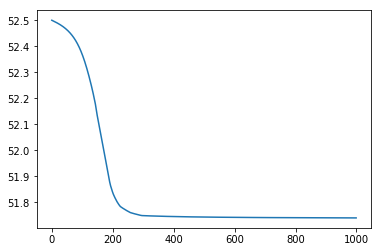

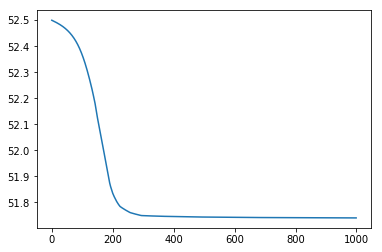

In [74]:
print hist.history.keys()
plt.figure()
plt.plot(hist.history['loss'])

plt.figure()
plt.plot(hist.history['val_loss'])